# Classifying sources detected by the Gaia satellite around the Andromeda galaxy

# Python packages used

In [15]:
from glob import glob  # Finds all the pathnames matching a specified pattern according to rules of Unix shell.

import numpy as np                                                              # Used for working with arrays.
import matplotlib.pyplot as plt       # Mainly intended for interactive plots and programmatic plot generation.
import seaborn as sns       # Provides a interface for drawing attractive and informative statistical graphics.

from astropy.io import fits                  # Provides access to FITS files (Flexible Image Transport System).
from astropy.io import ascii       # Provides methods for reading and writing a wide range of ASCII data table.
from astropy.table import Table     # Provides functionality for storing and manipulating heterogeneous tables.
import pandas as pd # Powerful and flexible to use open source data analysis and manipulation tool,

from photutils.isophote import EllipseGeometry  # Provides tools to fit elliptical isophotes to a galaxy image.
from photutils.isophote import Ellipse                   # Class to fit elliptical isophotes to a galaxy image.
from photutils.isophote import build_ellipse_model         # Build a model elliptical from a list of isophotes.

# Introduction:
Gaia is a European space mission providing astrometry, photometry, and spectroscopy of more than 1000 million stars in the Milky Way. Also data for significant samples of extragalactic and Solar system objects is made available.

Displaying all fits at same time

<ipython-input-32-c069629ef879>:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, (ax1) = plt.subplots(figsize=(5, 5))


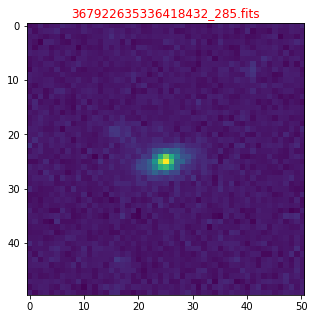

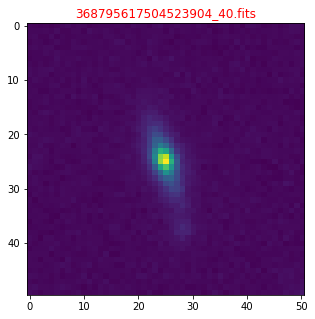

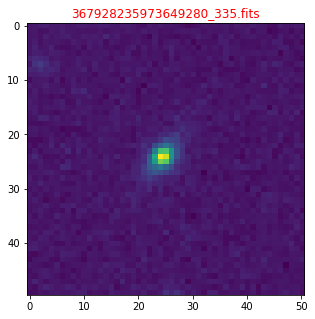

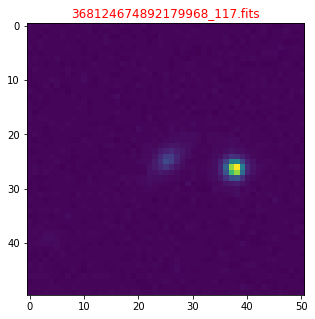

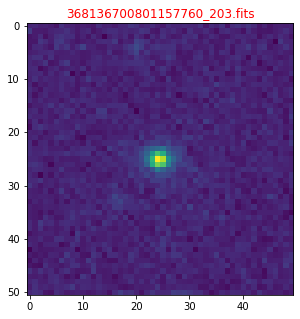

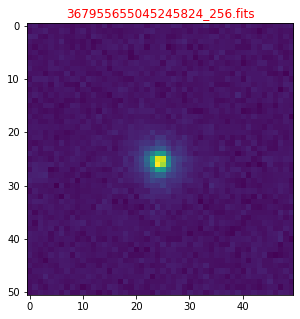

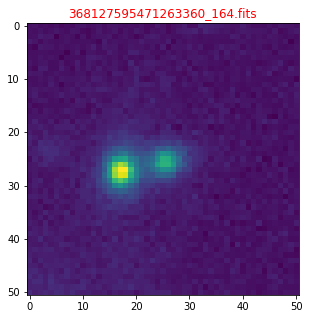

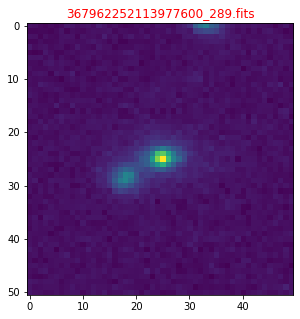

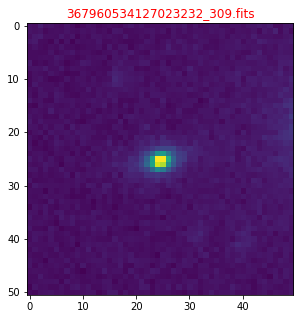

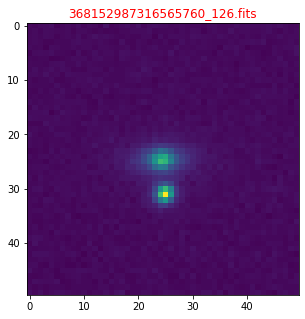

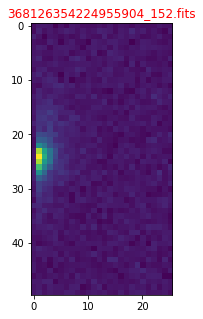

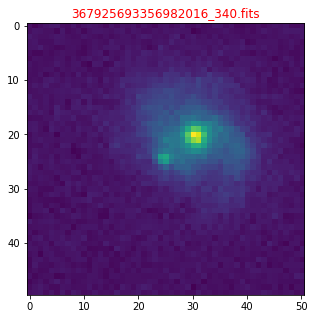

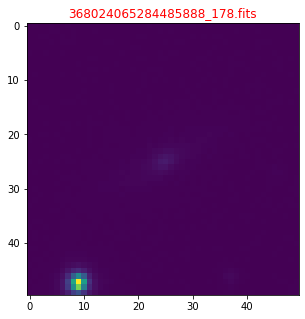

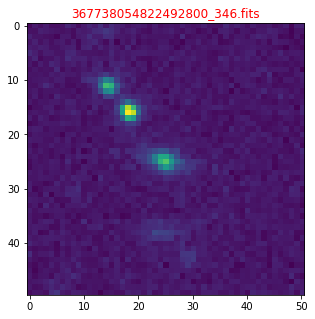

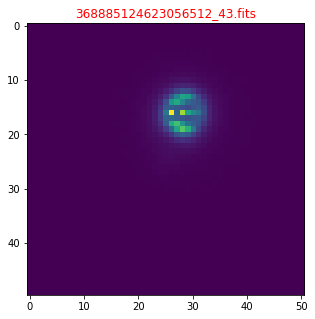

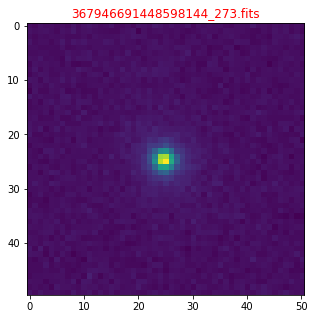

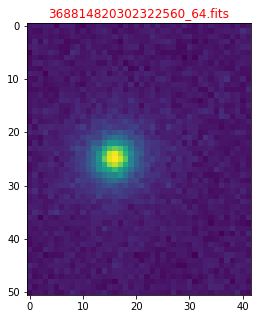

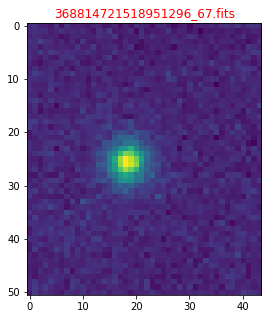

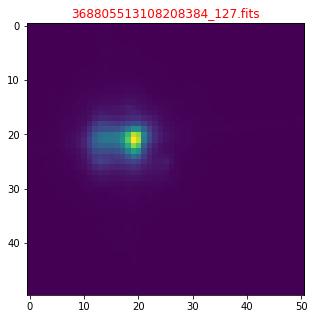

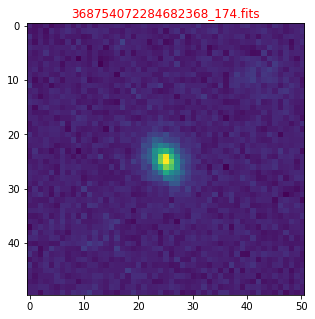

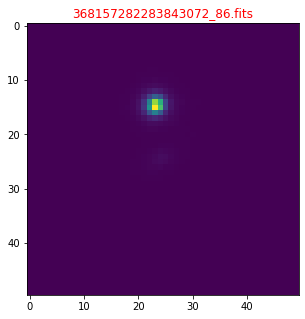

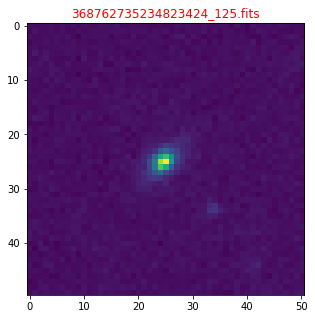

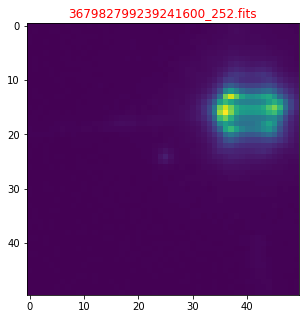

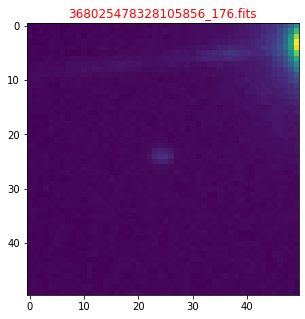

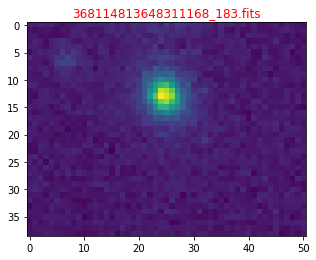

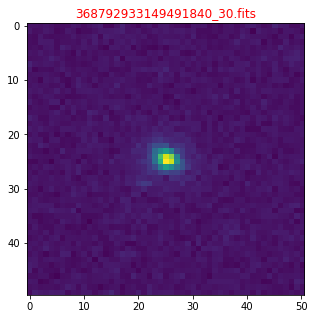

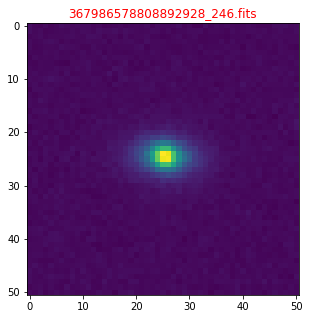

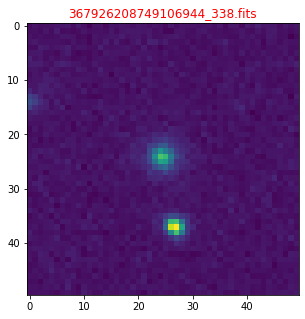

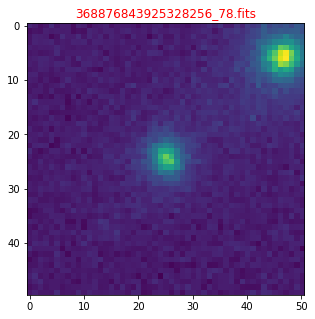

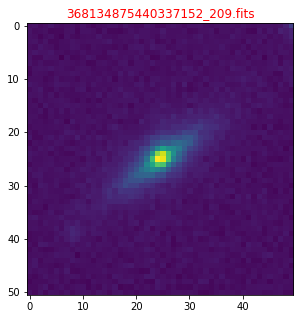

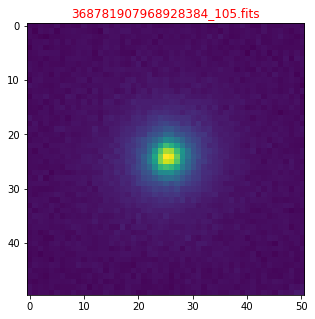

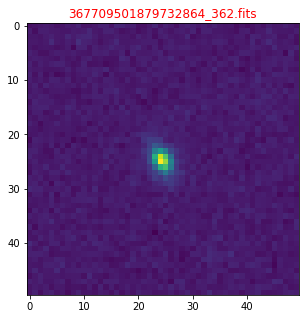

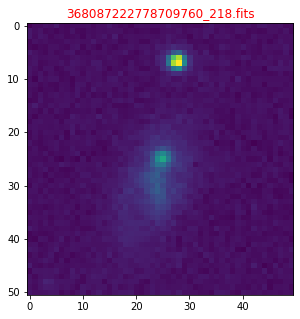

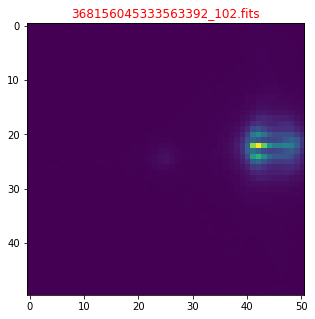

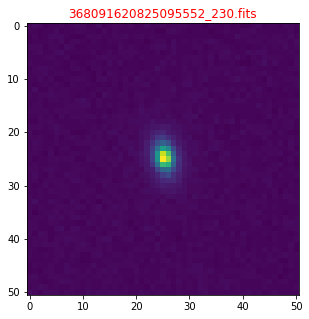

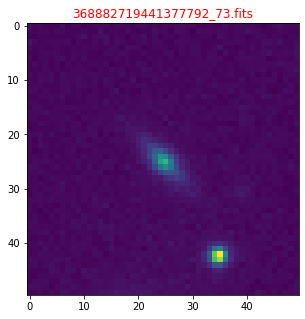

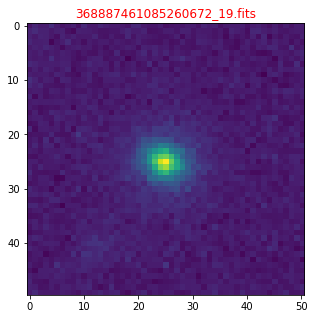

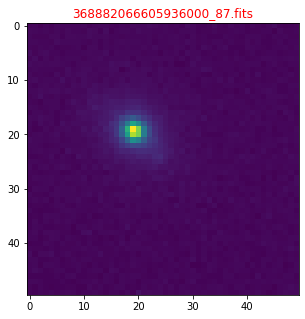

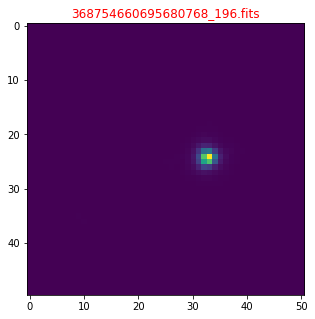

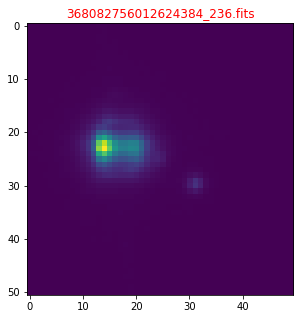

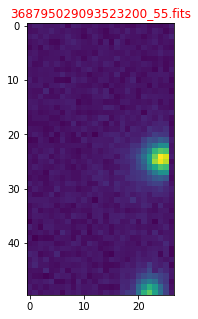

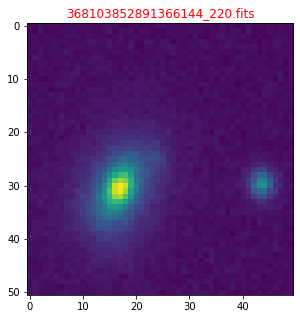

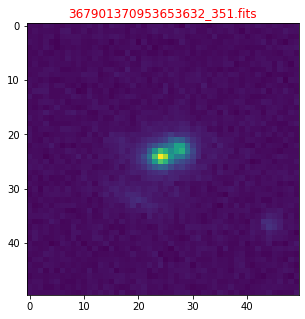

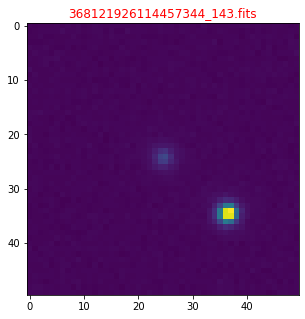

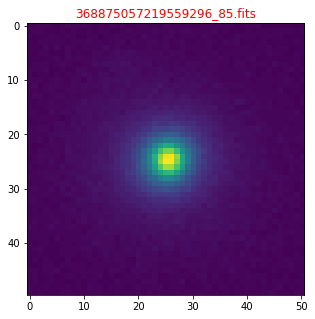

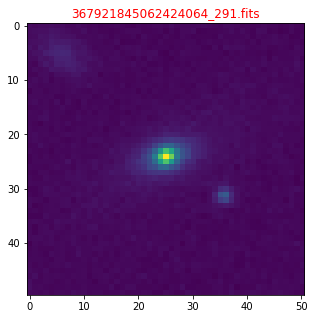

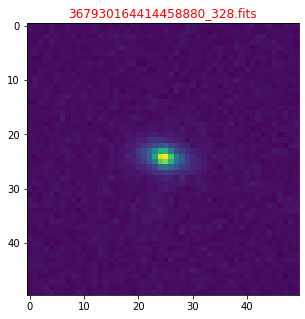

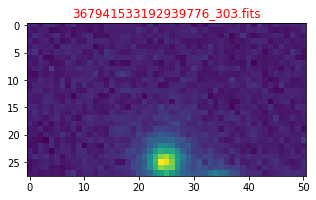

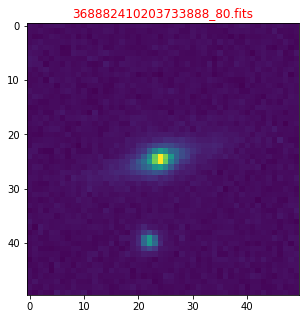

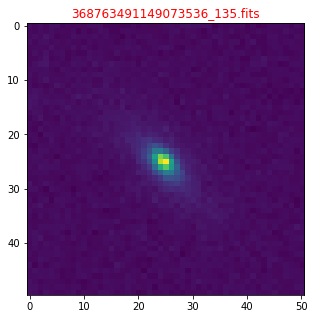

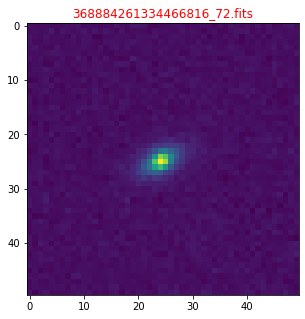

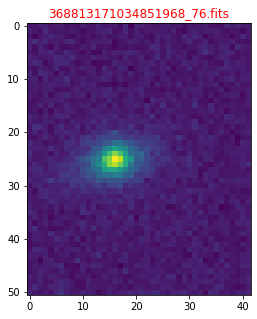

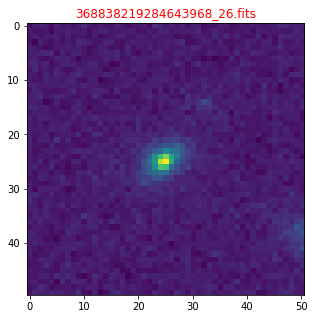

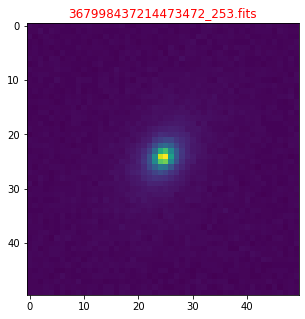

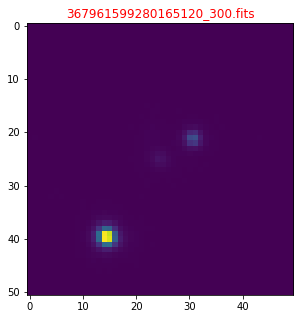

In [32]:
data = glob("*.fits")
for i in data:
    with fits.open(i) as hdu:
        data = hdu[0].data
        fig, (ax1) = plt.subplots(figsize=(5, 5))  
        ax1.imshow(data)            
        ax1.set_title(f'{i}', c='Red')
        hdu.close()

class to produce table

In [3]:
class U:                                  
    def __init__(self, name, sma, eps): 
        self._name = name
        self._sma = sma
        self._eps = eps

    def table(self):
        hdu = fits.open(self._name) 
        data = hdu[0].data
        hdu.close()
        geometry = EllipseGeometry(x0=25, y0=25, sma=self._sma, eps=self._eps, pa=np.radians(100)) 
        ellipse = Ellipse(data, geometry)
        isolist = ellipse.fit_image(sclip=2., nclip=3)
        tab = isolist.to_table()
        ascii.write(tab, f'{self._name}_table.ascii', overwrite=True) 
        
        model_image = build_ellipse_model(data.shape, isolist)
        residual = data - model_image
        plt.figure(figsize=(12, 7))
        plt.figure(1)
        
        minr = np.min(isolist.sma)
        maxr = np.max(isolist.sma)
        radinterp = np.linspace(minr, maxr, 10)
        epsinterp = np.interp(radinterp, isolist.sma, isolist.eps)
        painterp = np.interp(radinterp, isolist.sma, isolist.pa)
        
        plt.subplot(221)
        plt.title(self._name, c='Red')
        plt.errorbar(isolist.sma, isolist.eps, yerr=isolist.ellip_err, fmt='.', markersize=4)
        elip_median = [np.median(epsinterp)]*len(epsinterp)
        plt.errorbar(radinterp, elip_median, linestyle='-', label='median')
        elip_mean = [np.mean(epsinterp)]*len(epsinterp)
        plt.errorbar(radinterp, elip_mean, linestyle='--', label='mean')
        plt.xlabel('Semimajor axis length [pixels]', c='Blue')
        plt.ylabel('Ellipticity', c='Blue')
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
        
        plt.subplot(222)
        plt.title(self._name, c='Red')
        plt.errorbar(isolist.sma, isolist.pa/np.pi*180., yerr=isolist.pa_err/np.pi* 80., fmt='.', markersize=4)
        pa_median = [np.median(painterp/np.pi*180.)]*len(painterp)
        plt.errorbar(radinterp, pa_median, linestyle='-')
        pa_mean = [np.mean(painterp/np.pi*180.)]*len(painterp)
        plt.errorbar(radinterp, pa_mean, linestyle='--')
        plt.xlabel('Semimajor axis length [pixels]', c='Blue')
        plt.ylabel('PA [degrees]', c='Blue')
        
        plt.subplot(223)
        plt.title(self._name, c='Red')
        plt.errorbar(isolist.sma, isolist.x0, yerr=isolist.x0_err, fmt='.', markersize=4)
        y_median = [np.median(isolist.x0)]*len(isolist.sma)
        plt.errorbar(isolist.sma, y_median, linestyle='-', label='median')
        y_mean = [np.mean(isolist.x0)]*len(isolist.sma)
        plt.errorbar(isolist.sma, y_mean, linestyle='--', label='mean')
        plt.xlabel('Semimajor axis length [pixels]', c='Blue')
        plt.ylabel('X0', c='Blue')
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
        
        plt.subplot(224)
        plt.title(self._name, c='Red')
        plt.errorbar(isolist.sma, isolist.y0, yerr=isolist.y0_err, fmt='.', markersize=4)
        y_median = [np.median(isolist.y0)]*len(isolist.sma)
        plt.errorbar(isolist.sma, y_median, linestyle='-')
        y_mean = [np.mean(isolist.y0)]*len(isolist.sma)
        plt.errorbar(isolist.sma, y_mean, linestyle='--')
        plt.xlabel('Semimajor axis length [pixels]', c='Blue')
        plt.ylabel('Y0', c='Blue')
        plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.5, wspace=0.5)
        plt.savefig(f'{self._name}_plot.pdf')
        plt.close()
        
        meme = np.array([i, np.max(elip_median), np.max(pa_median), np.max(elip_mean), np.max(pa_mean)])
        ascii.write(meme, f'{self._name}_medmea.ascii', 
                    names=['name','ellipticity_median','position_angle_median','ellipticity_mean','position_angle_mean'],
                    overwrite=True) 
        
        
        fig, (ax1, ax2, ax3) = plt.subplots(figsize=(15, 10), nrows=1, ncols=3)
        fig.subplots_adjust(left=0.04, right=0.98, bottom=0.02, top=0.98)
        ax1.imshow(data, origin='lower')
        ax1.set_title(self._name, c='Blue')
        smas = np.linspace(2, 10, 5)
        for sma in smas:
            iso = isolist.get_closest(sma)
            x, y, = iso.sampled_coordinates()
            ax1.plot(x, y, color='white')
            ax2.imshow(model_image, origin='lower')
            ax2.set_title('Ellipse Model', c='Blue')
            ax3.imshow(residual, origin='lower')
            ax3.set_title('Residual', c='Blue')
            plt.savefig(f'{self._name}_model.pdf')
        plt.close()

In [4]:
data = glob("*.fits")
for i in data:
    imagen = U(i, 3.5, 0.15)
    imagen.table()

In [68]:
ls

367916042561917952_329.fits  changee/             sdss_data/
367961599280165120_300.fits  done/                zz2/
368114573130153088_191.fits  isolated.ipynb
368138762385947648_181.fits  resumen_ellipse.csv


# For only case

In [53]:
imagen = U("367709501879732864_362.fits",5, 0.3)
print(imagen.table())

None


# Plots

In [27]:
df=pd.read_csv("final_ellipse.csv")  
len(df)

311

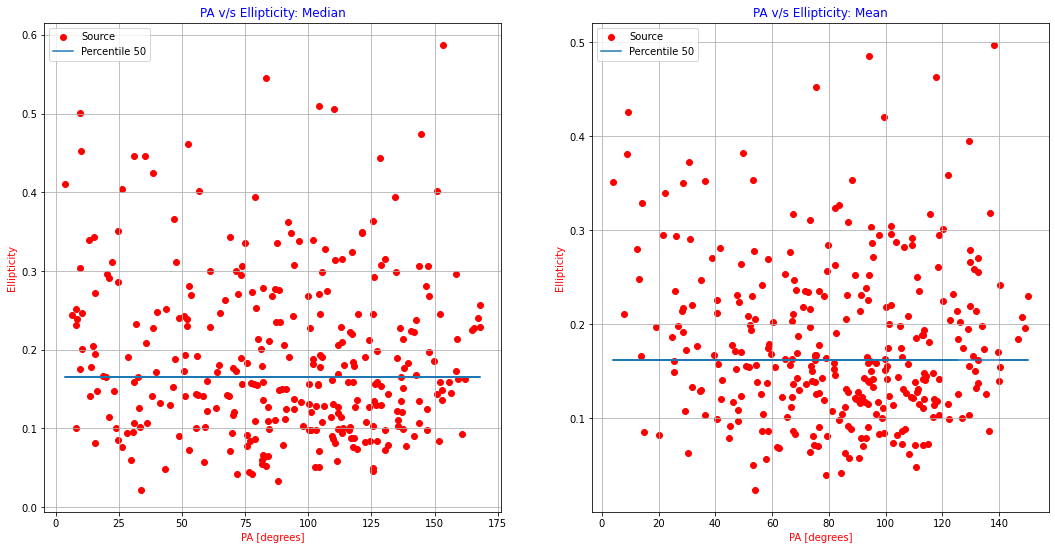

In [28]:
fig, (axa, axb) = plt.subplots(1, 2, figsize=(18,9))

axa.scatter(df.position_angle_median, df.ellipticity_median, c='red', label="Source")
y_mean = [np.percentile(df.ellipticity_median,50)]*len(df.position_angle_median)
axa.errorbar(df.position_angle_median, y_mean, linestyle='-', label="Percentile 50")
axa.set_xlabel('PA [degrees]', c='red')
axa.set_ylabel('Ellipticity', c='red')
axa.set_title('PA v/s Ellipticity: Median', c='Blue')
axa.grid(True)
axa.legend(loc='upper left')

axb.scatter(df.position_angle_mean, df.ellipticity_mean, c='red', label="Source")
ymean = [np.percentile(df.ellipticity_mean,50)]*len(df.position_angle_mean)
axb.errorbar(df.position_angle_mean, ymean, linestyle='-', label="Percentile 50")
axb.set_xlabel('PA [degrees]', c='red')
axb.set_ylabel('Ellipticity', c='red')
axb.set_title('PA v/s Ellipticity: Mean', c='blue')
axb.grid(True)
axb.legend(loc='upper left')

plt.show()
plt.savefig('PA_Ellipticity_plots.png')
plt.close()

In [29]:
print("median_50", np.percentile(df.ellipticity_median,50)) 
print("mean_50", np.percentile(df.ellipticity_mean,50))

median_50 0.16545226508010624
mean_50 0.16177312148591744


# PA v/s Ellipticity: Median

116 sources were select


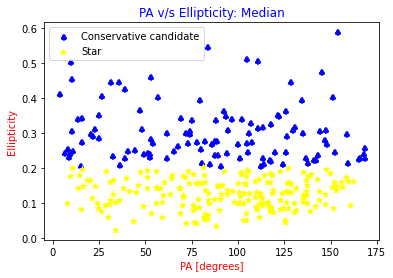

In [30]:
hola= df[(df["ellipticity_median"]>0.20307004733381714)]
chao= df[(df["ellipticity_median"]<0.20307004733381714)]
print(len(hola),'sources were select')

plt.scatter(hola["position_angle_median"], hola["ellipticity_median"], marker=r'$\clubsuit$', c="blue", label="Conservative candidate")
plt.scatter(chao["position_angle_median"], chao["ellipticity_median"], marker="*", c="yellow", label="Star")
plt.title('PA v/s Ellipticity: Median', c='Blue')
plt.xlabel('PA [degrees]',c='red')
plt.ylabel('Ellipticity', c='red')
plt.legend(loc='upper left')
plt.savefig('PA_Ellipticity_median.png')

# PA v/s Ellipticity: [mean]

104 sources were select


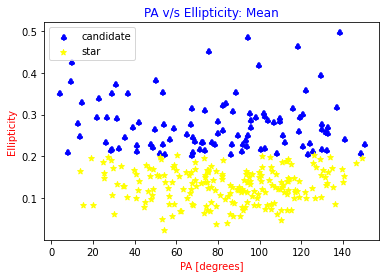

In [23]:
hi= df[(df["ellipticity_mean"]>0.20307004733381714)]
bye= df[(df["ellipticity_mean"]<0.20307004733381714)]
print(len(hi),'sources were select')

plt.scatter(hi["position_angle_mean"], hi["ellipticity_mean"], marker=r'$\clubsuit$', c="blue", label="candidate")
plt.scatter(bye["position_angle_mean"], bye["ellipticity_mean"], marker="*", c="yellow", label="star")
plt.title('PA v/s Ellipticity: Mean', c='Blue')
plt.xlabel('PA [degrees]',c='red')
plt.ylabel('Ellipticity', c='red')
plt.legend(loc='upper left')
plt.savefig('PA_Ellipticity_mean.png')

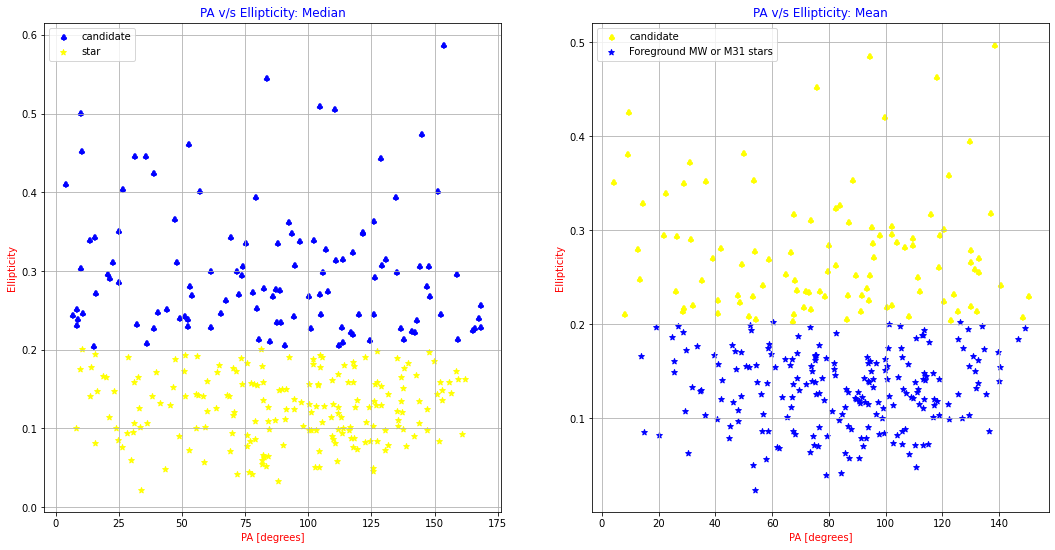

In [31]:
fig, (axa, axb) = plt.subplots(1, 2, figsize=(18,9))

axa.scatter(hola["position_angle_median"], hola["ellipticity_median"], marker=r'$\clubsuit$', c="blue", label="candidate")
axa.scatter(chao["position_angle_median"], chao["ellipticity_median"], marker='*', c="yellow", label="star")
axa.set_xlabel('PA [degrees]', c='red')
axa.set_ylabel('Ellipticity', c='red')
axa.set_title('PA v/s Ellipticity: Median', c='blue')
axa.grid(True)
axa.legend(loc='upper left')

axb.scatter(hi["position_angle_mean"], hi["ellipticity_mean"], marker=r'$\clubsuit$', c="yellow", label="candidate")
axb.scatter(bye["position_angle_mean"], bye["ellipticity_mean"], marker='*', c="blue", label="Foreground MW or M31 stars")
axb.set_xlabel('PA [degrees]', c='red')
axb.set_ylabel('Ellipticity', c='red')
axb.set_title('PA v/s Ellipticity: Mean', c='blue')
axb.grid(True)
axb.legend(loc='upper left')

plt.show()
plt.savefig('PA_Ellipticity_select.png')
plt.close()

# Statistics

In [25]:
df[(df["ellipticity_median"]>0.20307004733381714)]

,name,ellipticity_median,position_angle_median,ellipticity_mean,position_angle_mean
0,367601650955811328_278.fits,0.212139,123.947770,0.213808,125.178677
1,367601685315549568_277.fits,0.443984,128.309439,0.463476,117.853702
6,367735963173048192_352.fits,0.587311,153.397210,0.497384,138.183136
7,367736542993939968_357.fits,0.394303,78.966164,0.310964,73.354079
11,367742972558742144_350.fits,0.446254,30.978787,0.372251,30.691339
...,...,...,...,...,...
294,368887353709778688_17.fits,0.228941,167.943633,0.207084,148.192467
297,368891305079655808_21.fits,0.205487,90.251956,0.191027,82.357827
301,368901372483654400_5.fits,0.213885,158.875781,0.214411,131.926649
306,368909653181190528_24.fits,0.213876,80.240873,0.197007,73.241676


In [26]:
df[(df["ellipticity_mean"]>0.20307004733381714)]

,name,ellipticity_median,position_angle_median,ellipticity_mean,position_angle_mean
0,367601650955811328_278.fits,0.212139,123.947770,0.213808,125.178677
1,367601685315549568_277.fits,0.443984,128.309439,0.463476,117.853702
6,367735963173048192_352.fits,0.587311,153.397210,0.497384,138.183136
7,367736542993939968_357.fits,0.394303,78.966164,0.310964,73.354079
11,367742972558742144_350.fits,0.446254,30.978787,0.372251,30.691339
...,...,...,...,...,...
287,368883715873786624_47.fits,0.349682,121.307394,0.284192,109.262643
294,368887353709778688_17.fits,0.228941,167.943633,0.207084,148.192467
301,368901372483654400_5.fits,0.213885,158.875781,0.214411,131.926649
304,368908553669549056_49.fits,0.190591,92.484964,0.252034,89.117548


In [33]:
df.corr()
corr.style.background_gradient()

NameError: name 'corr' is not defined

We interpolate the output of the ellipse fitting task with a new vector that is regularly (linearly) spaced.
The interpolation is necessary because the output SMA of ellipse task is logarithmic. The logarithmic spacing
biases the median (or mean) ellipticity bacause it produces more points in the inner part of each object 
(which are more circular). Thereafore, the interpolated profile is needed, and gives an ellipticity more represenative 
of the whole distribution of light (inner and outer parts of the objects) 